# Topology Optimization of Thermo-Optical Phase SHifter (TOPS)

We first import all necessary modules and set warnings:

In [1]:
import numpy as np
from solver import freq_top_opt_2D
import matplotlib.pyplot as plt

%matplotlib inline
verbose = False
if not verbose:
    import warnings
    warnings.filterwarnings("ignore")

## Parameter initialization

First, we set up the **simulation parameters**:

In [2]:
res  =  0.05 #0.05  # inverse of resolution
scaling = res*1e-6 # the scale applied to the physical problem
nElx =  int(14/res) # the number of elements in the X axis
nEly =  int(4/res) # the number of elements in the Y axis
nodesX = nElx + 1
nodesY = nEly + 1

In [3]:
print(nElx)
print(nEly)

280
80


Then, we set up the **material parameters**:

In [4]:
n_metal = 3.1477 # refractive index for TiN
k_r =  5.8429  # exctinction coefficient for TiN
n_wg  = np.sqrt(15.054) # refractive index of the waveguide
n_clad = np.sqrt(4.2) # refractive index of cladding
dz = 200E-6
h_core = 1e-6 / scaling
w_core = 10e-6 / scaling  #10e-6 / scaling 

Next, we set the **physical parameters**:

In [5]:
wl = 1.55 / res  # value for the wavelentgth, i.e. 1.55 um.
k = 2 * np.pi / (wl * scaling) # value of the wavevector
delta = 3.8193 #3.86253 # Effective refractive index from COMSOL
deltaT = 3.825 #3.8694

In [6]:
print(k)
print(k*delta)
print((k)**2)
print((k*delta)**2)

4053667.940115862
15482173.963684512
16432223768723.176
239697710641790.6


Some checks:

In [7]:
print('Lenght of simulation domain in X: ', nElx*scaling)
print('Lenght of simulation domain in Y: ', nEly*scaling)
print('Wavelength of the problem: ', wl*scaling)
print('Dielectric constant (real part) of metal: ', n_metal**2)

Lenght of simulation domain in X:  1.4e-05
Lenght of simulation domain in Y:  4e-06
Wavelength of the problem:  1.55e-06
Dielectric constant (real part) of metal:  9.90801529


After, we set the **TopOpt parameters**:

In [8]:
fR = 4 # value for the filtering radius   
maxItr = 10 # number of iterations performed by the optimizer
alg = "MMA" # algorithm: Method of  Moving Asymptotes
eta = 0.5 # parameter that controls threshold value.
beta = 1E9     #1E9 # parameter that controls threshold sharpness.
vol_cons_val = 0.5 # Maximum value for volume constraint
heat_cons_val =  0.2# Maximum value for heat constraint

Finally, we set the **inital value for the design variables**:

In [9]:
dVini_Omega_1 = 0.0 # intial value of design parameters in Omega_1
dVini_Omega_3 = 0.0 # intial value of design parameters in Omega_3
nEl_Omega_3 = 0

In [10]:
nEly_heat = nEly
nElx_heat = nElx
nEly_EM = nEly
nElx_EM = nElx


volume1  = np.zeros((nEly_heat, nElx_heat))
volume2  = np.zeros((nEly_heat, nElx_heat))
volume4  = np.zeros((nEly_heat, nElx_heat))
volume5  = np.zeros((nEly_heat, nElx_heat))


volume3 = np.zeros((nEly_heat, nElx_heat))


h_domain = 4E-6 / scaling#10e-6


alpha = 0.0

w_non_design = w_core + alpha * (h_domain-h_core)
h_non_design = h_core + alpha * (h_domain-h_core)

w_design_limit = nElx_EM 
h_design_limit = nEly_EM


volume1 [nEly_heat//2 - int(0.5*h_core) : nEly_heat//2 + int(0.5*h_core),nElx_heat//2 - int(0.5*w_core) : nElx_heat//2 + int(0.5*w_core)] = 1 # waveguide region

volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)] = 1


volume5  = 1 
volume5_c  = 1 

volume5 = volume5 - volume1
volume5_c = volume5_c - volume1



indexes_design_limit = np.array(np.where(volume5<1))
volume4 [indexes_design_limit[0,:], indexes_design_limit[1,:]] = 1

indexes_design_limit_c = np.array(np.where(volume5_c<1))


volume3 [(nEly_heat)//2 - int(0.5*h_core) : (nEly_heat)//2 + int(0.5*h_core),(nElx_heat+1)//2 - int(0.5*w_core) : (nElx_heat)//2 + int(0.5*w_core)] = 1 # waveguide region
indexes_heating = np.array(np.where(volume3 > 0.5))
indexes_design_region_heat = np.array(np.where(volume5 == 1))
indexes_design_region_heat_c = np.array(np.where(volume5_c == 1))

indexes_RHS = np.array(np.where(volume3 < 1))

indexes_wg_heat = np.array(np.where(volume3 == 1))


volume2 [nEly_heat//2 - int(0.5*h_core)-nEl_Omega_3:nEly_heat//2 + int(0.5*h_core)+nEl_Omega_3,nElx_heat//2 - int(0.5*w_core)-nEl_Omega_3:nElx_heat//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating_heat = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint
indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_constraint] = dVini_Omega_3

h_metal = 0.2E-6 / scaling
w_metal = 4E-6 / scaling

print(h_metal)
print(w_metal)

volume4 [:, :] = 0.0
volume4 [nEly//2 + int(0.5*h_core) : nEly//2 + int(0.5*h_core) + int(h_metal) , nElx//2 - int(0.5*w_core) : nElx//2 - int(0.5*w_core) + int(w_metal)] = 1 # metal region
indexes_metal = np.array(np.where(volume4 > 0.5))

from wg_index import calc_index_constraint

indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating)).astype(int)
indexes_metal_heater = (calc_index_constraint(indexes_design_region_heat, indexes_metal)).astype(int)
dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
#dVini[:] = 0.5
dVini [indexes_metal_heater]= 1.0
volume1_heat = volume1


random = False
if random:
    dVini = np.random.rand(len(dVini))

4.0
80.0


In [11]:
nEly_heat = nEly
nElx_heat = nElx
nEly_EM = nEly
nElx_EM = nElx


volume1  = np.zeros((nEly_heat, nElx_heat))
volume2  = np.zeros((nEly_heat, nElx_heat))
volume4  = np.zeros((nEly_heat, nElx_heat))
volume5  = np.zeros((nEly_heat, nElx_heat))


volume3 = np.zeros((nEly_heat, nElx_heat))


h_domain = 4E-6 / scaling#10e-6


alpha = 0.0

w_non_design = w_core + alpha * (h_domain-h_core)
h_non_design = h_core + alpha * (h_domain-h_core)

w_design_limit = nElx_EM 
h_design_limit = nEly_EM


volume1 [nEly_heat//2 - int(0.5*h_core) : nEly_heat//2 + int(0.5*h_core),nElx_heat//2 - int(0.5*w_core) : nElx_heat//2 + int(0.5*w_core)] = 1 # waveguide region

volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)] = 1


volume5  = 1 
volume5_c  = 1 

volume5 = volume5 - volume1
volume5_c = volume5_c - volume1



indexes_design_limit = np.array(np.where(volume5<1))
volume4 [indexes_design_limit[0,:], indexes_design_limit[1,:]] = 1

indexes_design_limit_c = np.array(np.where(volume5_c<1))


volume3 [(nEly_heat)//2 - int(0.5*h_core) : (nEly_heat)//2 + int(0.5*h_core),(nElx_heat+1)//2 - int(0.5*w_core) : (nElx_heat)//2 + int(0.5*w_core)] = 1 # waveguide region
indexes_heating = np.array(np.where(volume3 > 0.5))
indexes_design_region_heat = np.array(np.where(volume5 == 1))
indexes_design_region_heat_c = np.array(np.where(volume5_c == 1))

indexes_RHS = np.array(np.where(volume3 < 1))

indexes_wg_heat = np.array(np.where(volume3 == 1))


volume2 [nEly_heat//2 - int(0.5*h_core)-nEl_Omega_3:nEly_heat//2 + int(0.5*h_core)+nEl_Omega_3,nElx_heat//2 - int(0.5*w_core)-nEl_Omega_3:nElx_heat//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating_heat = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint
indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_constraint] = dVini_Omega_3

h_metal = 0.2E-6 / scaling
w_metal = 4E-6 / scaling

print(h_metal)
print(w_metal)

volume4 [:, :] = 0.0
volume4 [nEly//2 + int(0.5*h_core) : nEly//2 + int(0.5*h_core) + int(h_metal) , nElx//2 - int(0.5*w_core) : nElx//2 - int(0.5*w_core) + int(w_metal)] = 1 # metal region
indexes_metal = np.array(np.where(volume4 > 0.5))

from wg_index import calc_index_constraint

indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating)).astype(int)
indexes_metal_heater = (calc_index_constraint(indexes_design_region_heat, indexes_metal)).astype(int)
dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
#dVini[:] = 0.5
dVini [indexes_metal_heater]= 1.0
volume1_heat = volume1


random = False
if random:
    dVini = np.random.rand(len(dVini))

4.0
80.0


In [12]:
indexes_wg_EM = indexes_wg_heat
indexes_design_region_EM = indexes_design_region_heat
indexes_heating_EM = indexes_heating_heat

In [13]:
RHS_heater = indexes_wg_heat
val_heater = 80e-3 * np.ones_like(indexes_design_region_heat)
#dz = 200e-6
k_wg = 148 
k_clad = 1.38 
k_metal = 28

In [14]:
vol_cons = 0.5
heat_cons =  0.2

We initialize the solver:

In [15]:
FOM_type='linear'


solver = freq_top_opt_2D( nElx_EM, 
                          nEly_EM,
                          nElx_heat, 
                          nEly_heat,
                          dVini,
                          w_core,
                          h_core,
                          n_metal,
                          k_r,
                          n_wg,
                          n_clad,
                          wl,
                          delta,
                          deltaT,  
                          fR,
                          eta,
                          beta,
                          scaling,
                          vol_cons_val,
                          FOM_type,
                          indexes_wg_EM,
                          indexes_wg_heat,
                          indexes_design_region_EM,
                          indexes_design_region_heat,
                          heat_cons_val,
                          indexes_heating_EM,
                          indexes_heating_heat,
                          continuation_scheme= True,
                          heating_constraint= False,
                          volume_constraint= False,
                          eliminate_excitation= False,
                          dz=dz,
                          k_wg = k_wg,
                          k_clad = k_clad,
                          k_metal = k_metal,
                          debug=False,
                          logfile=False
                        )

EDGE NUMBERING: (MAX, MIN): 
45159.0
0.0


## Eigenmode solution

sigma:  239697710641790.6
[-2.39698293e+14+9.25141111e+09j -2.39183767e+14+4.22749656e+10j
 -2.40027959e+14+2.81476544e+11j -2.39992543e+14-3.32360095e+11j
 -2.39432286e+14-3.50568262e+11j]
(113081, 5)
(113081, 5)
The effective index calculated by the eigensolver is:  (3.819304640591545-7.370506674787947e-05j)


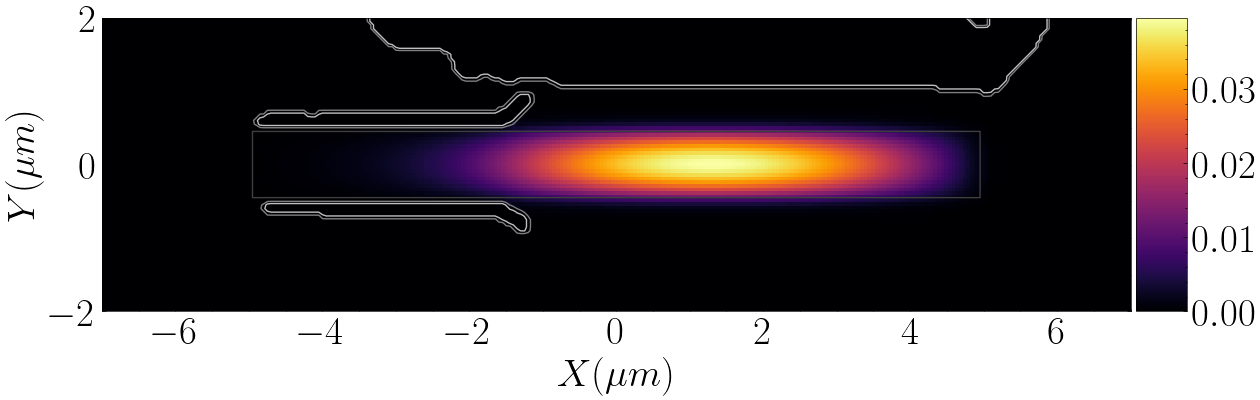

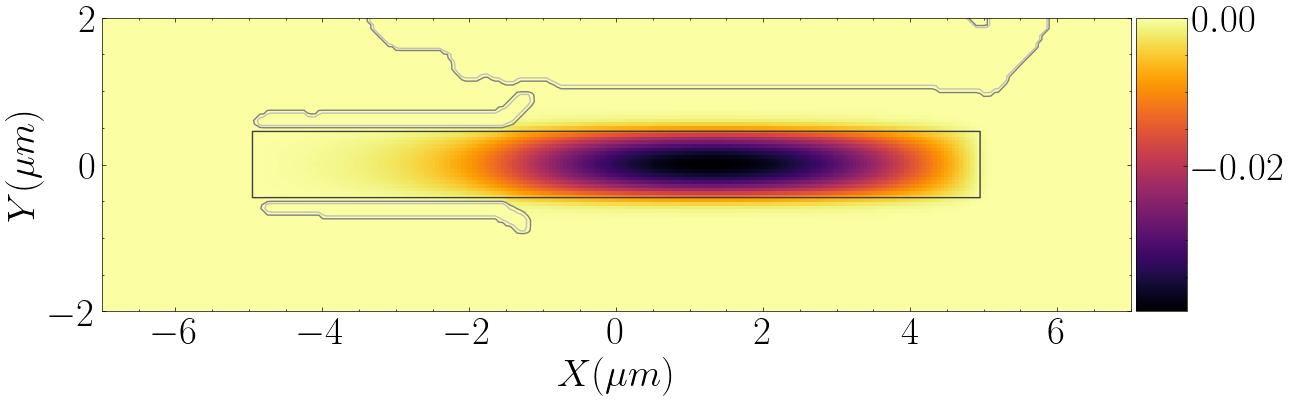

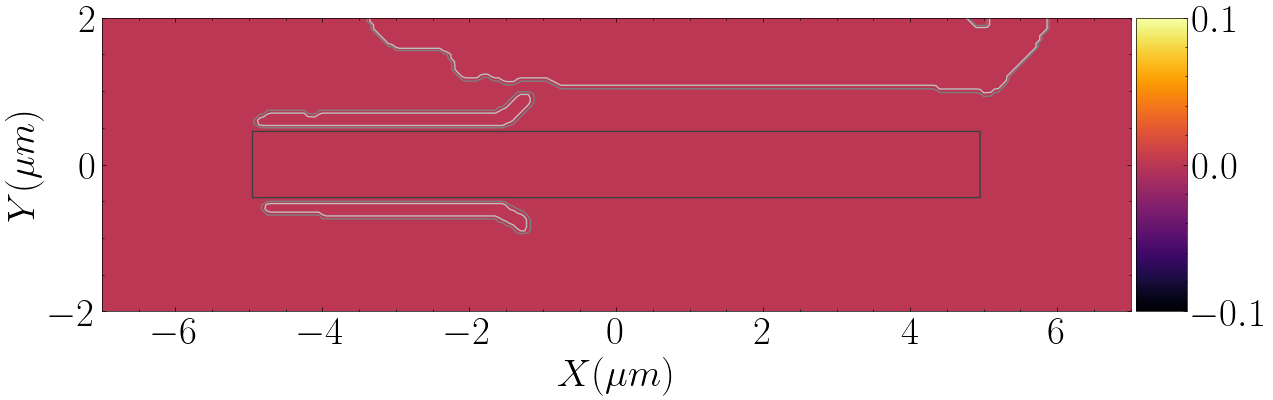

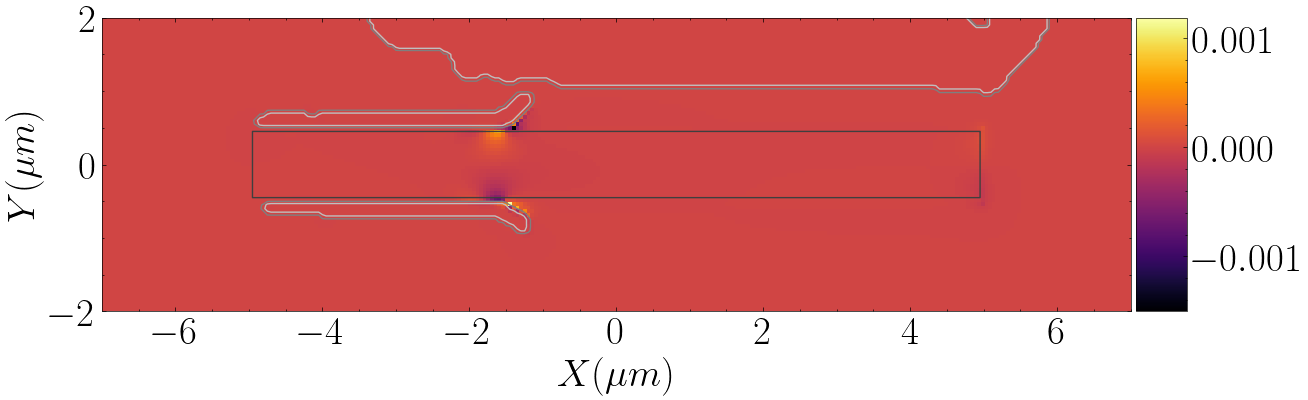

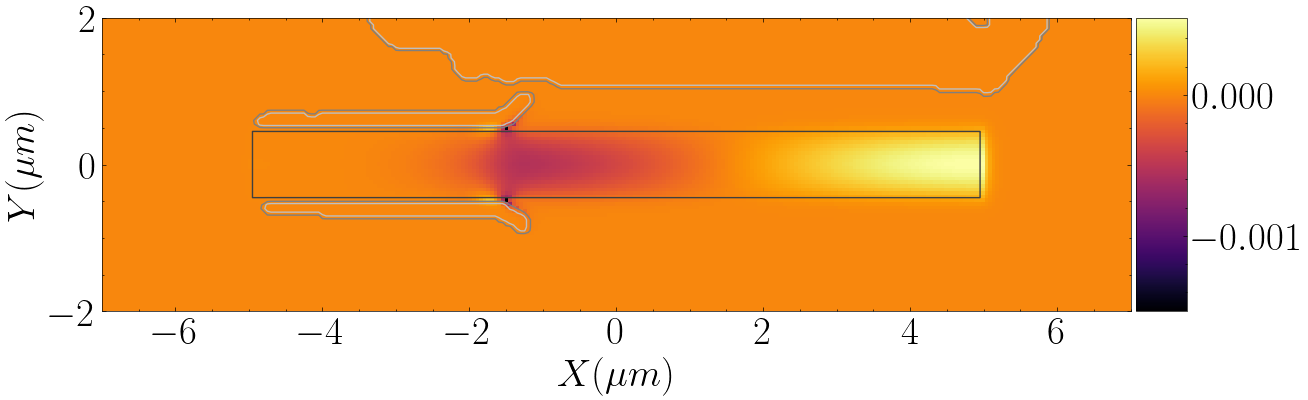

(array([ 6.13562881e-21, -7.13424650e-21, -3.21850444e-20, ...,
        -2.92452691e-19, -6.37936838e-20, -6.37936838e-20]),
 array([-1.60433288e-20,  1.50299767e-20,  1.96829418e-20, ...,
         8.37459275e-19,  3.69256340e-19, -4.71881144e-20]),
 array([-1.10664085e-20-5.19573082e-20j, -0.00000000e+00-0.00000000e+00j,
        -0.00000000e+00-0.00000000e+00j, ...,
        -0.00000000e+00-0.00000000e+00j, -0.00000000e+00-0.00000000e+00j,
        -3.79175583e-20+1.77406229e-20j]),
 None)

In [16]:
#dVs = np.load("dVs.npy")
dVs = dVini
dVs = np.load("dVs_fR_4_v_02.npy")
solver.solve_forward(dVs, solver='eigenmode', eigval_num=0)

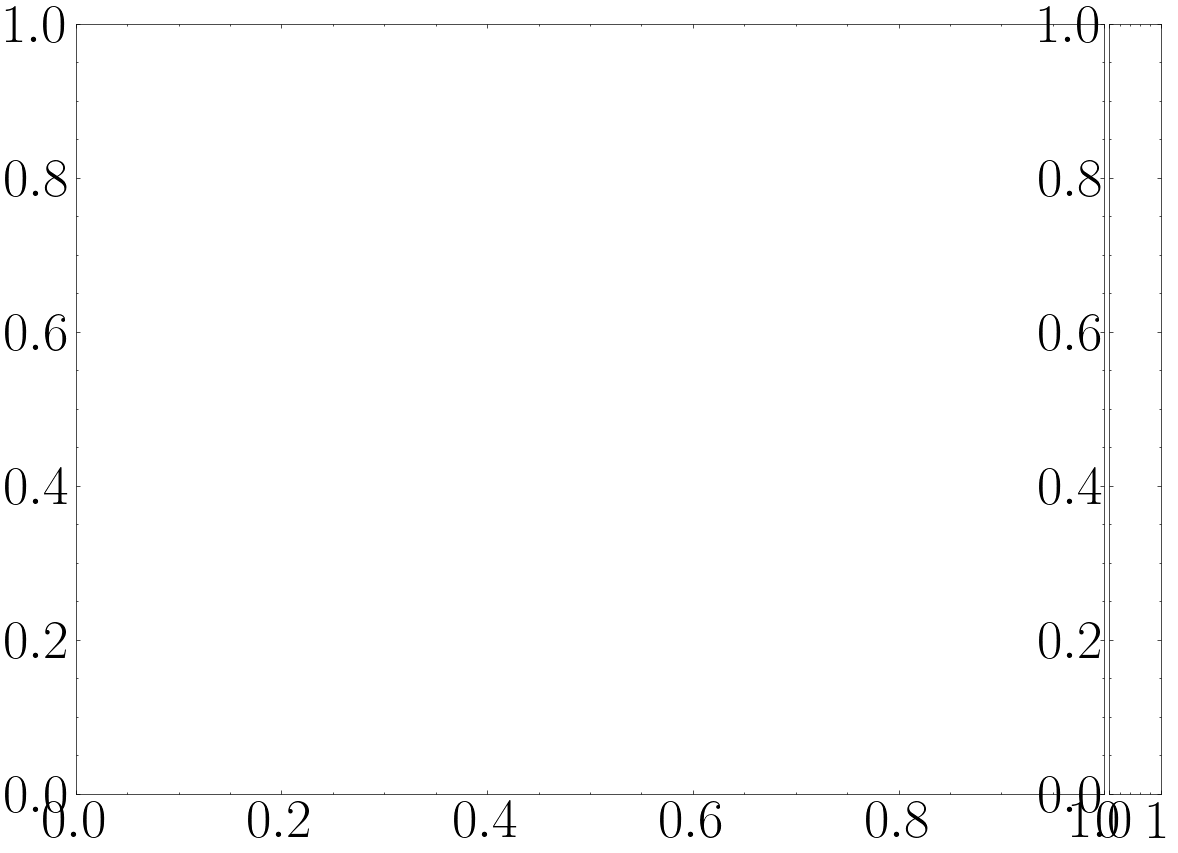

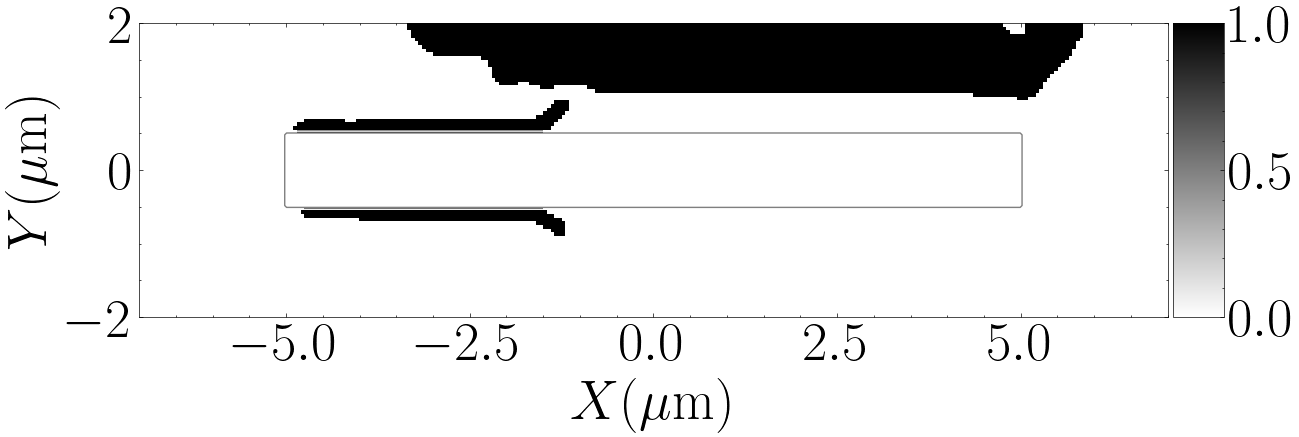

In [17]:
solver.plot_material_interpolation()

In [18]:
raise()

TypeError: exceptions must derive from BaseException

In [ ]:
dv = solver.dis_0.dFPST
np.save("oprimized_fR_10.npy", dv)

In [ ]:
dv = np.repeat(np.repeat(dv,10, axis=0), 10, axis=1)

In [ ]:
print(np.shape(dv))
print(nElx*4)
print(nEly*4)

In [ ]:
plt.imshow(np.real(dv), origin="lower")
plt.show()

In [ ]:
nEly_heat = nEly*10
nElx_heat = nElx*10
nEly_EM = nEly*10
nElx_EM = nElx*10


volume1  = np.zeros((nEly_heat, nElx_heat))
volume2  = np.zeros((nEly_heat, nElx_heat))
volume4  = np.zeros((nEly_heat, nElx_heat))
volume5  = np.zeros((nEly_heat, nElx_heat))


volume3 = np.zeros((nEly_heat, nElx_heat))


h_domain = 4E-6 / scaling#10e-6


alpha = 0.0

w_non_design = w_core + alpha * (h_domain-h_core)
h_non_design = h_core + alpha * (h_domain-h_core)

w_design_limit = nElx_EM 
h_design_limit = nEly_EM


volume1 [nEly_heat//2 - int(0.5*h_core) : nEly_heat//2 + int(0.5*h_core),nElx_heat//2 - int(0.5*w_core) : nElx_heat//2 + int(0.5*w_core)] = 1 # waveguide region

volume4 [nEly_heat//2 - int(0.5*h_non_design) : nEly_heat//2 + int(0.5*h_non_design),nElx_heat//2 - int(0.5*w_non_design) : nElx_heat//2 + int(0.5*w_non_design)] = 1


volume5  = 1 
volume5_c  = 1 

volume5 = volume5 - volume1
volume5_c = volume5_c - volume1



indexes_design_limit = np.array(np.where(volume5<1))
volume4 [indexes_design_limit[0,:], indexes_design_limit[1,:]] = 1

indexes_design_limit_c = np.array(np.where(volume5_c<1))


volume3 [(nEly_heat)//2 - int(0.5*h_core) : (nEly_heat)//2 + int(0.5*h_core),(nElx_heat+1)//2 - int(0.5*w_core) : (nElx_heat)//2 + int(0.5*w_core)] = 1 # waveguide region
indexes_heating = np.array(np.where(volume3 > 0.5))
indexes_design_region_heat = np.array(np.where(volume5 == 1))
indexes_design_region_heat_c = np.array(np.where(volume5_c == 1))

indexes_RHS = np.array(np.where(volume3 < 1))

indexes_wg_heat = np.array(np.where(volume3 == 1))


volume2 [nEly_heat//2 - int(0.5*h_core)-nEl_Omega_3:nEly_heat//2 + int(0.5*h_core)+nEl_Omega_3,nElx_heat//2 - int(0.5*w_core)-nEl_Omega_3:nElx_heat//2 + int(0.5*w_core)+nEl_Omega_3] = 1 # non-constraint region
volume3 = volume2 - volume1
indexes_heating_heat = np.array(np.where(volume3 > 0.5))
from wg_index import calc_index_constraint
indexes_constraint = (calc_index_constraint(indexes_design_region_heat, indexes_heating_heat)).astype(int)

dVini = dVini_Omega_1 *  np.ones_like(np.array(indexes_design_region_heat[0,:]).flatten()) 
dVini [indexes_constraint] = dVini_Omega_3

h_metal = 0.2E-6 / scaling
w_metal = 4E-6 / scaling

print(h_metal)
print(w_metal)

volume4 [:, :] = 0.0
volume4 [nEly//2 + int(0.5*h_core) : nEly//2 + int(0.5*h_core) + int(h_metal) , nElx//2 - int(0.5*w_core) : nElx//2 - int(0.5*w_core) + int(w_metal)] = 1 # metal region
indexes_metal = np.array(np.where(volume4 > 0.5))

In [ ]:
from filter_threshold import filter_threshold

fR = 2 * 10

filThr =  filter_threshold(fR, nElx_EM, nEly_EM, eta, 1E9) 

In [ ]:
dFPS = filThr.density_filter(np.ones((nEly_EM, nElx_EM), dtype="complex128"), filThr.filSca, dv, np.ones((nEly_EM, nElx_EM), dtype="complex128"))
dFPST = filThr.threshold(dFPS)

In [ ]:
plt.imshow(np.real(dFPST), origin="lower")
plt.show()

In [ ]:
np.save("oprimized_fR_10_v_02.npy", dFPST)